In [1]:
import sys

from src.gauss_hist import get_gauss_stats

PWD = '../../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers

from src.network_utils import count_params, plot_difference_hist, gaussian_kernel, dist_kernel, get_dist_root
from src.cross_validator import CrossValidator
from src.dataset import load_dataset_train_test, X_TIME, TIME_STEP
from src.models import optimal_model_builders_ch_2_11 as optimal_model_builders

In [2]:
PROJECT_NAME = 'compare'

PLANE = 2
CHANNEL = 11

OVERWRITE = False

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_{PLANE}_{CHANNEL}/cross_val'

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048

CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 3
LOSS_WEIGHT_REGULAR = 1000
LOSS_WEIGHT_HEATMAP = 1000
LOSS_WEIGHT_DIST = 1000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test(PWD, PLANE, CHANNEL)

X_base_train.shape

(22412, 24)

In [4]:
y_base_train_heatmap = np.array([gaussian_kernel(y) for y in y_base_train])
y_base_train_dist = np.array([dist_kernel(y) for y in y_base_train])

y_base_train_heatmap.shape, y_base_train_dist.shape

((22412, 24), (22412, 24))

In [5]:
def compile_wrapper(builder, loss_weight):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=loss_weight)
        return model

    return compiled_builder

# Regular models

Number of parameters: 1345
Got score: 85.0376 (84.7964, 85.2010, 85.1152)
Got score: 84.4898 (84.6418, 83.9476, 84.8799)
Got score: 82.0576 (82.0214, 81.9595, 82.1919)
Got score: 84.2333 (83.8579, 84.6182, 84.2239)
Got score: 85.8855 (85.6439, 86.5334, 85.4792)


Number of parameters: 68001
Got score: 84.9853 (85.1951, 84.5479, 85.2128)
Got score: 84.0696 (84.2272, 84.0633, 83.9182)
Got score: 81.8997 (81.4828, 82.1041, 82.1123)
Got score: 83.7832 (83.3432, 84.0442, 83.9623)
Got score: 85.5797 (85.6401, 85.5535, 85.5453)


Number of parameters: 264545
Got score: 85.3222 (85.2237, 85.4774, 85.2655)
Got score: 84.7565 (84.9556, 85.2193, 84.0945)
Got score: 81.9850 (82.0512, 81.5354, 82.3684)
Got score: 84.3319 (84.6983, 84.1607, 84.1367)
Got score: 85.7149 (85.9457, 85.9802, 85.2187)


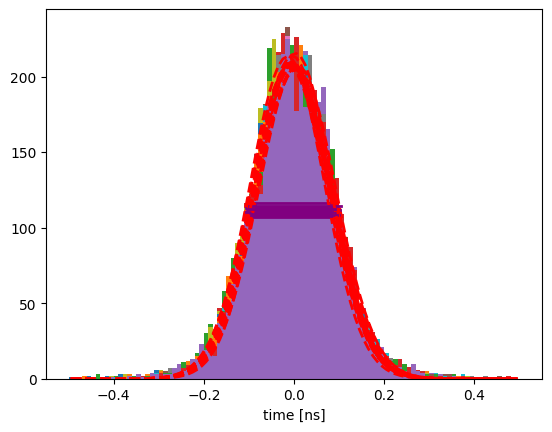

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.convnet, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.rnn, loss_weight=LOSS_WEIGHT_REGULAR),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = CrossValidator(regular_model_builders, X_base_train, y_base_train, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                 eval_metric=regular_metric, overwrite=OVERWRITE)

regular_model_scores = cross_validator()

# Heatmap-based models

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet, loss_weight=LOSS_WEIGHT_HEATMAP)]
heatmap_model_names = ['unet']

cross_validator = CrossValidator(heatmap_model_builders, X_base_train, y_base_train_heatmap, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=heatmap_model_names,
                                 eval_metric=heatmap_metric, overwrite=OVERWRITE)

heatmap_model_scores = cross_validator()

Number of parameters: 16929
Got score: 84.5621 (85.0888, 84.0611, 84.5364)
Got score: 84.3781 (83.8078, 84.6866, 84.6400)
Got score: 81.3443 (81.6479, 81.2567, 81.1282)
Got score: 83.7855 (84.4622, 83.1120, 83.7824)
Got score: 84.7740 (84.8799, 84.7091, 84.7331)


# Dist-based models

In [8]:
def dist_metric(y_dist_true, y_dist_pred):
    y_true = np.empty(y_dist_true.shape[0])
    for i, y in enumerate(y_dist_true):
        y_true[i] = get_dist_root(y)

    y_pred = np.empty(y_dist_pred.shape[0])
    for i, y in enumerate(y_dist_pred):
        y_pred[i] = get_dist_root(y)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


dist_model_builders = [compile_wrapper(optimal_model_builders.unet_dist, loss_weight=LOSS_WEIGHT_DIST)]
dist_model_names = ['unet_dist']

cross_validator = CrossValidator(dist_model_builders, X_base_train, y_base_train_dist, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=dist_model_names,
                                 eval_metric=dist_metric, overwrite=OVERWRITE)

dist_model_scores = cross_validator()

Number of parameters: 367041
Got score: 86.7498 (87.8529, 87.0871, 85.3093)
Got score: 86.0392 (84.8935, 86.0412, 87.1828)
Got score: 83.1590 (83.9926, 82.1155, 83.3689)
Got score: 88.4536 (84.7163, 93.5797, 87.0646)
Got score: 86.0336 (86.5345, 85.5024, 86.0640)


# Comparison

In [9]:
all_model_builders = regular_model_builders + heatmap_model_builders + dist_model_builders
all_model_names = regular_model_names + heatmap_model_names + dist_model_names
all_model_scores = regular_model_scores | heatmap_model_scores | dist_model_scores

In [10]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,84.34,1.27,1345
convnet,84.06,1.26,68001
rnn,84.42,1.31,264545
unet,83.77,1.26,16929
unet_dist,86.09,1.71,367041
